In [10]:
# -*- coding: utf-8 -*-

# # 1. Import bibliotek i ustawienia

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ustawienie losowości dla powtarzalności
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Ustawienie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Urządzenie: {device}")



# # 2. Pobranie i przygotowanie danych


# Wybór datasetu: 'MNIST' lub 'EMNIST'
dataset_name = 'MNIST'  # lub 'EMNIST'
# Jeśli EMNIST: wybierz split, np. 'balanced', 'letters', 'digits', itp.
emnist_split = 'balanced'

# Transformacje: do jednego kanału, normalizacja
img_size = 28  # MNIST już 28x28; EMNIST też
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Ścieżka do katalogu z danymi
data_root = './data'

if dataset_name == 'MNIST':
    # MNIST: train i test
    train_full = MNIST(root=data_root, train=True, download=True, transform=transform)
    test_dataset = MNIST(root=data_root, train=False, download=True, transform=transform)
    classes = [str(i) for i in range(10)]
    num_classes = 10
    # Jeśli chcemy około 10000 rekordów: weźmy losowy podzbiór z train_full
    desired_total = 10000
    if len(train_full) >= desired_total:
        indices = list(range(len(train_full)))
        rnd = torch.Generator().manual_seed(seed)
        subset_indices = torch.randperm(len(train_full), generator=rnd)[:desired_total].tolist()
        subset_train = Subset(train_full, subset_indices)
    else:
        print(f"Train dataset MNIST ma mniej niż {desired_total} obrazów: używamy pełnego zbioru train (rozmiar {len(train_full)})")
        subset_train = train_full
    # Podział subset_train na train/val/test proporcje 80/10/10 w ramach subsetu
    num_samples = len(subset_train)
    train_size = int(0.8 * num_samples)
    val_size = int(0.1 * num_samples)
    test_size = num_samples - train_size - val_size
    train_dataset, val_dataset, extra_test = random_split(subset_train, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    # Można połączyć extra_test z test_dataset lub traktować oddzielnie. Tutaj traktujemy oddzielnie: finalny test to test_dataset z MNIST pełnym.
    # Jeśli chcemy testować tylko na extra_test, można to zmienić.
    use_full_test = True
elif dataset_name == 'EMNIST':
    # EMNIST: train i test w podziale split
    # Wymaga konwersji obrazów: EMNIST zapisane w pionie? torchvision automatycznie rotuje?
    train_full = EMNIST(root=data_root, split=emnist_split, train=True, download=True, transform=transform)
    test_dataset = EMNIST(root=data_root, split=emnist_split, train=False, download=True, transform=transform)
    classes = train_full.classes if hasattr(train_full, 'classes') else None
    # Jeśli brak classes, można generować etykiety jako indeksy
    num_classes = len(train_full.classes) if hasattr(train_full, 'classes') else len(set(train_full.targets.tolist()))
    # Podzbiór ~10000 z train_full
    desired_total = 10000
    if len(train_full) >= desired_total:
        indices = list(range(len(train_full)))
        rnd = torch.Generator().manual_seed(seed)
        subset_indices = torch.randperm(len(train_full), generator=rnd)[:desired_total].tolist()
        subset_train = Subset(train_full, subset_indices)
    else:
        print(f"Train dataset EMNIST ma mniej niż {desired_total} obrazów: używamy pełnego zbioru train (rozmiar {len(train_full)})")
        subset_train = train_full
    num_samples = len(subset_train)
    train_size = int(0.8 * num_samples)
    val_size = int(0.1 * num_samples)
    test_size = num_samples - train_size - val_size
    train_dataset, val_dataset, extra_test = random_split(subset_train, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    use_full_test = True
else:
    raise ValueError("Nieznany dataset_name. Wybierz 'MNIST' lub 'EMNIST'.")

print(f"Rozkład: Train: {len(train_dataset)}, Val: {len(val_dataset)}")
if use_full_test:
    print(f"Dostępny oddzielny zbiór testowy: {len(test_dataset)} obrazów")
else:
    print(f"Test (z subsetu): {len(extra_test)} obrazów")

# DataLoaders
dataloader_params = {'batch_size': 64, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {'batch_size': 64, 'shuffle': True}
train_loader = DataLoader(train_dataset, **dataloader_params)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4) if torch.cuda.is_available() else DataLoader(val_dataset, batch_size=64, shuffle=False)
if use_full_test:
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4) if torch.cuda.is_available() else DataLoader(test_dataset, batch_size=64, shuffle=False)
else:
    test_loader = DataLoader(extra_test, batch_size=64, shuffle=False, num_workers=4) if torch.cuda.is_available() else DataLoader(extra_test, batch_size=64, shuffle=False)



# # 3. Definicja własnej architektury CNN

class HandwritingCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandwritingCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # 7x7 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = HandwritingCNN(num_classes=num_classes).to(device)
print(model)


# %%
# # 4. Funkcje treningu i walidacji

# %%
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(dataloader, desc="Trenowanie", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Walidacja", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# %%
# # 5. Trenowanie modelu

# %%
epochs = 30
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_val_acc = 0.0
save_path = "handwriting_cnn_best.pth"
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    print(f"Epoka {epoch}/{epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"  Zapisano najlepszy model, Val Acc: {best_val_acc:.4f}")



# # 6. Ocena na zbiorze testowym

# Wczytanie najlepszego modelu
model.load_state_dict(torch.load(save_path, map_location=device))

test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



Urządzenie: cuda
Rozkład: Train: 8000, Val: 1000
Dostępny oddzielny zbiór testowy: 10000 obrazów
HandwritingCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoka 1/30


  Train Loss: 0.8920, Train Acc: 0.7007
  Val   Loss: 0.1784, Val   Acc: 0.9460
  Zapisano najlepszy model, Val Acc: 0.9460
Epoka 2/30


  Train Loss: 0.2082, Train Acc: 0.9357
  Val   Loss: 0.1176, Val   Acc: 0.9660
  Zapisano najlepszy model, Val Acc: 0.9660
Epoka 3/30


  Train Loss: 0.1479, Train Acc: 0.9536
  Val   Loss: 0.0848, Val   Acc: 0.9750
  Zapisano najlepszy model, Val Acc: 0.9750
Epoka 4/30


  Train Loss: 0.1061, Train Acc: 0.9686
  Val   Loss: 0.0713, Val   Acc: 0.9790
  Zapisano najlepszy model, Val Acc: 0.9790
Epoka 5/30


  Train Loss: 0.0936, Train Acc: 0.9709
  Val   Loss: 0.0599, Val   Acc: 0.9810
  Zapisano najlepszy model, Val Acc: 0.9810
Epoka 6/30


  Train Loss: 0.0793, Train Acc: 0.9759
  Val   Loss: 0.0655, Val   Acc: 0.9780
Epoka 7/30


  Train Loss: 0.0669, Train Acc: 0.9769
  Val   Loss: 0.0655, Val   Acc: 0.9780
Epoka 8/30


  Train Loss: 0.0652, Train Acc: 0.9791
  Val   Loss: 0.0783, Val   Acc: 0.9740
Epoka 9/30


  Train Loss: 0.0640, Train Acc: 0.9799
  Val   Loss: 0.0672, Val   Acc: 0.9810
Epoka 10/30


  Train Loss: 0.0488, Train Acc: 0.9828
  Val   Loss: 0.0633, Val   Acc: 0.9800
Epoka 11/30


  Train Loss: 0.0455, Train Acc: 0.9850
  Val   Loss: 0.0576, Val   Acc: 0.9810
Epoka 12/30


  Train Loss: 0.0461, Train Acc: 0.9849
  Val   Loss: 0.0639, Val   Acc: 0.9850
  Zapisano najlepszy model, Val Acc: 0.9850
Epoka 13/30


  Train Loss: 0.0351, Train Acc: 0.9885
  Val   Loss: 0.0566, Val   Acc: 0.9820
Epoka 14/30


  Train Loss: 0.0404, Train Acc: 0.9874
  Val   Loss: 0.0610, Val   Acc: 0.9850
Epoka 15/30


  Train Loss: 0.0362, Train Acc: 0.9885
  Val   Loss: 0.0548, Val   Acc: 0.9860
  Zapisano najlepszy model, Val Acc: 0.9860
Epoka 16/30


  Train Loss: 0.0320, Train Acc: 0.9895
  Val   Loss: 0.0606, Val   Acc: 0.9820
Epoka 17/30


  Train Loss: 0.0329, Train Acc: 0.9890
  Val   Loss: 0.0596, Val   Acc: 0.9830
Epoka 18/30


  Train Loss: 0.0300, Train Acc: 0.9904
  Val   Loss: 0.0763, Val   Acc: 0.9800
Epoka 19/30


  Train Loss: 0.0292, Train Acc: 0.9905
  Val   Loss: 0.0597, Val   Acc: 0.9850
Epoka 20/30


  Train Loss: 0.0242, Train Acc: 0.9925
  Val   Loss: 0.0577, Val   Acc: 0.9860
Epoka 21/30


  Train Loss: 0.0249, Train Acc: 0.9916
  Val   Loss: 0.0881, Val   Acc: 0.9750
Epoka 22/30


  Train Loss: 0.0232, Train Acc: 0.9912
  Val   Loss: 0.0537, Val   Acc: 0.9880
  Zapisano najlepszy model, Val Acc: 0.9880
Epoka 23/30


  Train Loss: 0.0314, Train Acc: 0.9905
  Val   Loss: 0.0557, Val   Acc: 0.9840
Epoka 24/30


  Train Loss: 0.0171, Train Acc: 0.9936
  Val   Loss: 0.0617, Val   Acc: 0.9860
Epoka 25/30


  Train Loss: 0.0220, Train Acc: 0.9925
  Val   Loss: 0.0545, Val   Acc: 0.9850
Epoka 26/30


  Train Loss: 0.0232, Train Acc: 0.9919
  Val   Loss: 0.0693, Val   Acc: 0.9810
Epoka 27/30


  Train Loss: 0.0186, Train Acc: 0.9938
  Val   Loss: 0.0643, Val   Acc: 0.9860
Epoka 28/30


  Train Loss: 0.0161, Train Acc: 0.9936
  Val   Loss: 0.0630, Val   Acc: 0.9880
Epoka 29/30


  Train Loss: 0.0279, Train Acc: 0.9921
  Val   Loss: 0.0472, Val   Acc: 0.9870
Epoka 30/30


  Train Loss: 0.0215, Train Acc: 0.9926
  Val   Loss: 0.0509, Val   Acc: 0.9880


Test Loss: 0.0438, Test Acc: 0.9876


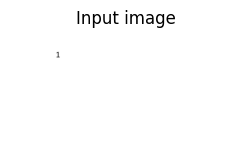

Predykcja: 1
Pewność: 36.32%


In [12]:
# %%
# # 7. Przykładowe przewidywanie na nowych obrazach

# %%
def inference_image(model, image_path, transform, classes, device):
    """
    Wykonuje predykcję na pojedynczym obrazie.

    Args:
        model (torch.nn.Module): Wytrenowany model.
        image_path (str): Ścieżka do pliku obrazu.
        transform (torchvision.transforms.Compose): Transformacje do zastosowania na obrazie.
        classes (list): Lista nazw klas.
        device (torch.device): Urządzenie (CPU/GPU).

    Returns:
        tuple: Przewidziana etykieta i poziom pewności.
    """
    # Wczytanie i przygotowanie obrazu
    img = Image.open(image_path).convert('L') # Konwersja na grayscale

    # Wyświetlenie obrazu
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Input image")
    plt.show()

    # Transformacja i dodanie wymiaru batcha
    tensor = transform(img).unsqueeze(0).to(device)

    model.eval() # Ustawienie modelu w tryb ewaluacji
    with torch.no_grad():
        outputs = model(tensor)
        probs = F.softmax(outputs, dim=1) # Obliczenie prawdopodobieństw
        conf, pred_idx = torch.max(probs, dim=1) # Najwyższe prawdopodobieństwo i indeks klasy

    label = classes[pred_idx.item()]
    confidence = conf.item()

    print(f"Predykcja: {label}")


    return label, confidence


try:


    image_path = "3.png" # <--- ZMIEŃ TO NA SWOJĄ ŚCIEŻKĘ DO OBRAZU

    # Wczytaj architekturę i wagi
    model_inf = HandwritingCNN(num_classes=num_classes).to(device)
    model_inf.load_state_dict(torch.load(save_path, map_location=device))

    # Wykonaj inferencję
    label, conf = inference_image(model_inf, image_path, transform, classes, device)

except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku obrazu pod ścieżką '{image_path}'.")
    print("Upewnij się, że ścieżka do obrazu jest poprawna i plik istnieje.")
except Exception as e:
    print(f"Wystąpił błąd podczas inferencji: {e}")